Не существует общего решения проблемы с отсутствующими данными. Для каждого конкретного случая приходится подбирать наиболее подходящие методы или их комбинации. При этом каждая модель уникальна и часто предполагает случайность, поэтому невозможно предсказать заранее, какая комбинация методов сработает на ваших данных лучше всего.

ОТБРАСЫВАНИЕ ЗАПИСЕЙ И ПРИЗНАКОВ

Первая техника — самая простая из всех. Она предполагает простое удаление записей или признаков, в которых содержатся пропуски. 

Здесь важно правильно выбрать ось удаления: если мы избавимся от большого числа строк, то рискуем потерять важные данные, а если мы удалим столбцы, то можем потерять важные признаки.

Специалисты рекомендуют при использовании метода удаления придерживаться следующих правил: удаляйте столбец, если число пропусков в нем более 30-40 %. В остальных случаях лучше удалять записи.

Для удаления строк и столбцов будем использовать метод dropna(), который позволяет удалять пропуски с тонким подходом к настройке. 

Основные параметры метода:

axis — ось, по которой производится удаление (по умолчанию 0 — строки).
how — как производится удаление строк (any — если хотя бы в одном из столбцов есть пропуск, стоит по умолчанию; all — если во всех столбцах есть пропуски). 
thresh — порог удаления. Определяет минимальное число непустых значений в строке/столбце, при котором она/он сохраняется. Например, если мы установим thresh в значение 2, то мы удалим строки, где число пропусков больше чем n-2, где n — число признаков (если axis=0).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
sber_data = pd.read_csv('data/sber_data.csv')
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)

Предварительно создадим копию исходной таблицы — drop_data, чтобы не повредить её. Зададимся порогом в 70 %: будем оставлять только те столбцы, в которых 70 и более процентов записей не являются пустыми . После этого удалим записи, в которых содержится хотя бы один пропуск. Наконец, выведем информацию о числе пропусков и наслаждаемся нулями.

In [3]:
#создаем копию исходной таблицы
drop_data = sber_data.copy()
#задаем минимальный порог: вычисляем 70% от числа строк
thresh = drop_data.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
drop_data = drop_data.dropna(thresh=thresh, axis=1)
#удаляем записи, в которых есть хотя бы 1 пропуск
drop_data = drop_data.dropna(how='any', axis=0)
#отображаем результирующую долю пропусков
drop_data.isnull().mean()

id                                       0.0
full_sq                                  0.0
life_sq                                  0.0
floor                                    0.0
sub_area                                 0.0
preschool_quota                          0.0
preschool_education_centers_raion        0.0
school_quota                             0.0
school_education_centers_raion           0.0
school_education_centers_top_20_raion    0.0
healthcare_centers_raion                 0.0
university_top_20_raion                  0.0
sport_objects_raion                      0.0
additional_education_raion               0.0
culture_objects_top_25_raion             0.0
shopping_centers_raion                   0.0
office_raion                             0.0
oil_chemistry_raion                      0.0
railroad_terminal_raion                  0.0
nuclear_reactor_raion                    0.0
metro_min_avto                           0.0
metro_km_avto                            0.0
metro_min_

ЗАПОЛНЕНИЕ НЕДОСТАЮЩИХ ЗНАЧЕНИЙ КОНСТАНТАМИ

Чтобы дырявая бочка не протекала, вставьте в дырку пробку. С этой мыслью связан другой способ бороться с пропусками — заполнение константами. 

Чаще всего пустые места заполняют средним/медианой/модой для числовых признаков и модальным значением для категориальных признаков. Вся сложность заключается в выборе метода заполнения. Важным фактором при выборе метода является распределение признаков с пропусками. Давайте выведем их на экран. 

В pandas это можно сделать с помощью метода hist():

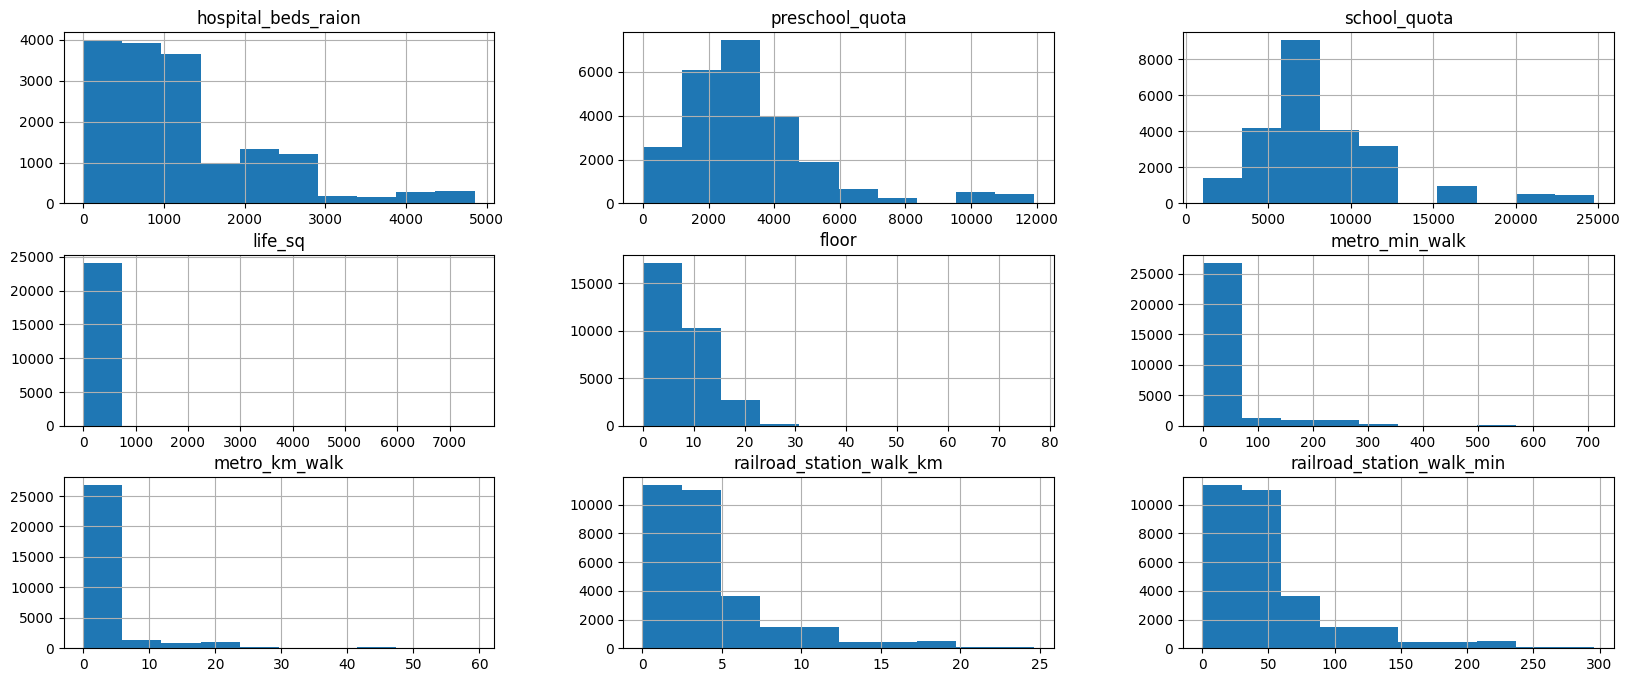

In [4]:
cols = cols_with_null.index
sber_data[cols].hist(figsize=(20, 8));

Итак, рассмотрим несколько рекомендаций.

Для распределений, похожих на логнормальное, где пик близ нуля, а далее наблюдается постепенный спад частоты, высока вероятность наличия выбросов (о них мы поговорим чуть позже). Математически доказывается, что среднее очень чувствительно к выбросам, а вот медиана — нет. Поэтому предпочтительнее использовать медианное значение для таких признаков.

Если признак числовой и дискретный (например, число этажей, школьная квота), то их заполнение средним/медианой является ошибочным, так как может получиться число, которое не может являться значением этого признака. Например, количество этажей — целочисленный признак, а расчёт среднего может дать 2.871. Поэтому такой признак заполняют либо модой, либо округляют до целого числа (или нужного количества знаков после запятой) среднее/медиану.

Категориальные признаки заполняются либо модальным значением, либо, если вы хотите оставить информацию о пропуске в данных, значением 'unknown'. На наше счастье, пропусков в категориях у нас нет.

Иногда в данных бывает такой признак, основываясь на котором, можно заполнить пропуски в другом. Например, в наших данных есть признак full_sq (общая площадь квартиры). Давайте исходить из предположения, что, если жилая площадь (life_sq) неизвестна, то она будет равна суммарной площади!

Заполнение значений осуществляется с помощью метода fillna(). Главный параметр метода — value (значение, на которое происходит заполнение данных в столбце). Если метод вызывается от имени всего DataFrame, то в качестве value можно использовать словарь, где ключи — названия столбцов таблицы, а значения словаря — заполняющие константы. 

Создадим такой словарь, соблюдая рекомендации, приведённые выше, а также копию исходной таблицы. Произведём операцию заполнения с помощью метода fillna() и удостоверимся, что пропусков в данных больше нет:

In [5]:
#создаем копию исходной таблицы
fill_data = sber_data.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'life_sq': fill_data['full_sq'],
    'metro_min_walk': fill_data['metro_min_walk'].median(),
    'metro_km_walk': fill_data['metro_km_walk'].median(),
    'railroad_station_walk_km': fill_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': fill_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': fill_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': fill_data['preschool_quota'].mode()[0],
    'school_quota': fill_data['school_quota'].mode()[0],
    'floor': fill_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()

id                   0.0
full_sq              0.0
life_sq              0.0
floor                0.0
sub_area             0.0
                    ... 
theater_km           0.0
museum_km            0.0
ecology              0.0
mosque_count_1000    0.0
price_doc            0.0
Length: 61, dtype: float64

Обратите внимание на то, как сильно изменилось распределение для признака hospital_beds_raion. Это связано с тем, что мы заполнили модальным значением почти 47 % общих данных. В результате мы кардинально исказили исходное распределение признака, что может плохо сказаться на модели.

Недостаток метода заполнения константой состоит в том, что мы можем «нафантазировать» новые данные, которые не учитывают истинного распределения.

ЗАПОЛНЕНИЕ НЕДОСТАЮЩИХ ЗНАЧЕНИЙ КОНСТАНТАМИ С ДОБАВЛЕНИЕМ ИНДИКАТОРА

Если мы используем заполнение пропусков константами, может быть, имеет смысл сказать модели о том, что на этом месте был пропуск? 

Давайте добавим к нашим данным признаки-индикаторы, которые будут сигнализировать о том, что в столбце на определённом месте в таблице был пропуск. Это место в столбце-индикаторе будем помечать как True. 

Посмотрим на реализацию. Как обычно, создадим копию indicator_data исходной таблицы. В цикле пройдёмся по столбцам с пропусками и будем добавлять в таблицу новый признак (с припиской "was_null"), который получается из исходного с помощью применения метода isnull(). После чего произведём обычное заполнение пропусков, которое мы совершали ранее, и выведем на экран число отсутствующих значений в столбце, чтобы убедиться в результате:

In [6]:
#создаем копию исходной таблицы
indicator_data = sber_data.copy()
#в цикле пробегаемся по названиям столбцов с пропусками
for col in cols_with_null.index:
    #создаем новый признак-индикатор как col_was_null
    indicator_data[col + '_was_null'] = indicator_data[col].isnull()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски   
values = {
    'life_sq': indicator_data['full_sq'],
    'metro_min_walk': indicator_data['metro_min_walk'].median(),
    'metro_km_walk': indicator_data['metro_km_walk'].median(),
    'railroad_station_walk_km': indicator_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': indicator_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': indicator_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': indicator_data['preschool_quota'].mode()[0],
    'school_quota': indicator_data['school_quota'].mode()[0],
    'floor': indicator_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
indicator_data = indicator_data.fillna(values)
#выводим результирующую долю пропусков
indicator_data.isnull().mean()

id                                    0.0
full_sq                               0.0
life_sq                               0.0
floor                                 0.0
sub_area                              0.0
                                     ... 
floor_was_null                        0.0
metro_min_walk_was_null               0.0
metro_km_walk_was_null                0.0
railroad_station_walk_km_was_null     0.0
railroad_station_walk_min_was_null    0.0
Length: 70, dtype: float64

Метод исходит из предположения, что, если дать модели информацию о том, что в ячейке ранее была пустота, то она будет меньше доверять таким записям и меньше учитывать её в процессе обучения. Иногда такие фишки действительно работают, иногда не дают эффекта, а иногда и вовсе могут ухудшить результат обучения и затруднить процесс обучения.

Когда мы добавляем признаки-индикаторы, мы повышаем размерность наших данных. Теперь представьте, что столбцов с пропусками сотня, по паре штук в каждом. 

Не нужно знать высшую математику, чтобы понять, что в таком случае мы увеличим размерность исходной таблицы ещё на сотню и 99 % строк этих столбцов будут заполнены нулями (False). При увеличении размерности в данных время обучения некоторых моделей растет экспоненциально — увеличив число признаков в два раза, вы увеличите время обучения в 7.38 раза! И при этом, возможно, даже не получите прироста в качестве. 

Более того, существует такое понятие, как проклятие размерности. Когда мы с вами будем обучать модели, мы будем искать глобальный минимум некоторой функции потерь. Размерность этой функции определяется числом признаков, на которых мы обучаем алгоритм. 

Проклятие размерности гласит, что, увеличивая размерность функции, мы повышаем сложность поиска этого минимума и рискуем вовсе не найти его! Об этом страшном проклятии мы ещё будем говорить в курсе по ML и даже попробуем его победить. Но об этом чуть позже.

Однако, несмотря на свои недостатки, этот метод кажется наиболее логичным из предложенных ранее и часто используется в очистке данных.

КОМБИНИРОВАНИЕ МЕТОДОВ

Наверняка вы уже догадались, что необязательно использовать один метод. Вы можете их комбинировать. Например, мы можем:

удалить столбцы, в которых более 30 % пропусков;
удалить записи, в которых более двух пропусков одновременно;
заполнить оставшиеся ячейки константами.
Посмотрим на реализацию такого подхода в коде:

In [7]:
#создаём копию исходной таблицы
combine_data = sber_data.copy()

#отбрасываем столбцы с числом пропусков более 30% (100-70)
n = combine_data.shape[0] #число строк в таблице
thresh = n*0.7
combine_data = combine_data.dropna(thresh=thresh, axis=1)

#отбрасываем строки с числом пропусков более 2 в строке
m = combine_data.shape[1] #число признаков после удаления столбцов
combine_data = combine_data.dropna(thresh=m-2, axis=0)

#создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
values = {
    'life_sq': combine_data['full_sq'],
    'metro_min_walk': combine_data['metro_min_walk'].median(),
    'metro_km_walk': combine_data['metro_km_walk'].median(),
    'railroad_station_walk_km': combine_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': combine_data['railroad_station_walk_min'].median(),
    'preschool_quota': combine_data['preschool_quota'].mode()[0],
    'school_quota': combine_data['school_quota'].mode()[0],
    'floor': combine_data['floor'].mode()[0]
}
#заполняем оставшиеся записи константами в соответствии со словарем values
combine_data = combine_data.fillna(values)
#выводим результирующую долю пропусков
display(combine_data.isnull().mean())

id                                       0.0
full_sq                                  0.0
life_sq                                  0.0
floor                                    0.0
sub_area                                 0.0
preschool_quota                          0.0
preschool_education_centers_raion        0.0
school_quota                             0.0
school_education_centers_raion           0.0
school_education_centers_top_20_raion    0.0
healthcare_centers_raion                 0.0
university_top_20_raion                  0.0
sport_objects_raion                      0.0
additional_education_raion               0.0
culture_objects_top_25_raion             0.0
shopping_centers_raion                   0.0
office_raion                             0.0
oil_chemistry_raion                      0.0
railroad_terminal_raion                  0.0
nuclear_reactor_raion                    0.0
metro_min_avto                           0.0
metro_km_avto                            0.0
metro_min_

РЕЗЮМЕ ПО МЕТОДАМ РАБОТЫ С ПРОПУСКАМИ

Итак, мы рассмотрели основные методы решения проблемы с недостающей информацией, а также их недостатки. 

Ещё раз хотим подчеркнуть, что выбор метода или комбинации методов является исключительно вашим решением. Однако важно держать в голове несколько рекомендаций:

Если какой-то из признаков имеет более 30-40 % пропусков, лучше избавьтесь от него: его заполнение может привести к сильному искажению общего распределения, а удаление записей — к большой утрате данных. Однако если этот признак очень важен для прогнозирования, вам придётся поколдовать над ним, чтобы «заплатки», которыми вы закрываете пропуски, выглядели правдоподобно.
Заполняйте данные с умом! Если перед вами количественный признак, то использование нецелого числа в качестве константы является как минимум нелогичным.
Вы можете оставить пропуски как есть, просто заменив их на какой-то специальный символ. Например, для числовых неотрицательных признаков можно использовать число -1, а для категориальных — строку 'unknown'.
Если вам позволяют сроки вашего проекта, попробуйте несколько кардинально разных подходов работы с пропусками.

ДРУГИЕ МЕТОДЫ ЗАПОЛНЕНИЯ ОТСУТСТВУЮЩИХ ЗНАЧЕНИЙ

Существуют и другие популярные способы избавиться от дыр в данных. Приведём только идею методов и их краткое описание.

Например, можно предсказать пропуски с помощью модели. Такой подход основывается на том, что вы считаете признак с отсутствующими значениями целевым, а остальные признаки — факторами и строите модель, предсказывающую пропуски в данных. На практике часто для заполнения «дыр» в данных используют метод ближайшего соседа (KNN) или линейную регрессию.

Ещё один подход — заполнение, основанное на группах. Можно сгруппировать данные по некоторым признакам и заполнять константой, полученной в группе. Например, в наших данных для признака жилой площади можно было бы заполнять пропуски средней площадью квартир в районе.